## Part A

Write MATLAB code that generates samples from this distribution. 

Plot the distribution of $r$ for a single draw of $x$ as a histogram (i.e., generate a single random
vector $x$ and use this to draw multiple samples of $r|x$ to generate the histogram). Try the same
with drawing different $x$ repeatedly.

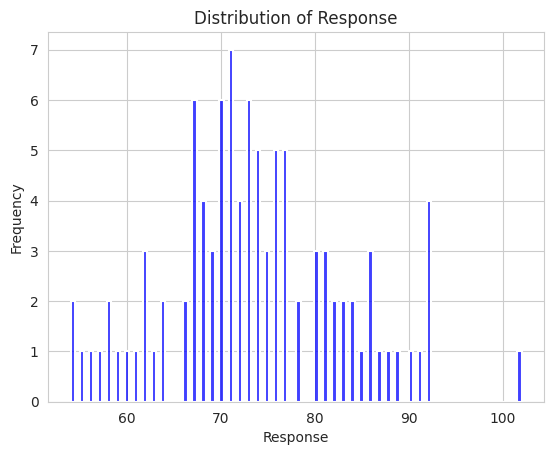

In [1]:
import seaborn as sns
from sthom215_problem_1_ex_2 import Neuron
import seaborn as sns

num_nerurons = 1
neuron = Neuron(100, mu=0, sigma=1)
# Simulate the neuron by using returned intesnity to simulate poisson spikes
resp = neuron.spiking()
import matplotlib.pyplot as plt

# Set the style and color palette
sns.despine()
sns.set_style("whitegrid")
sns.set_palette("pastel")

# Plot the histogram
sns.histplot(resp, bins=100, kde=False, color="b", edgecolor="w", linewidth=1.5)

# Add labels and title
plt.xlabel("Response")
plt.ylabel("Frequency")
plt.title("Distribution of Response")

# Show the plot
plt.show()


## Part B

Now generate a single response draw for each of M different stimuli $ x_m $, $ m = 1, ..., M $,
where M should be a parameter in your code that is easily adjustable. The response vector should
now be an $ M $ dimensional vector $ r $ ∈ $ \mathbb{R}^M $ with a corresponding matrix $ X = [x_1, ..., x_M] $ containing
all of your generated stimuli. Often in higher dimensional settings we linearize models, in this
case assuming that $ r \approx Xg $ with added independent, identically distributed (i.i.d.) Gaussian
noise. Set up a probabilistic relationship (likelihood) of $ r $ conditioned on $ g $ under a Gaussian
noise assumption. Specifically, assume that $ r = Xg + \epsilon $ where $ \epsilon $ is a mean-zero, Gaussian noise
vector with variance $ \sigma^2I $. Use the likelihood derived to set up a maximum likelihood inference of
$ g $ given the responses and stimuli (hint: think least-squares). 

In [6]:
import numpy as np
import numpy.linalg as la
from sthom215_problem_1_ex_2 import Neuron

num_nerurons = 200
n_trials = 100
neurons =  Neuron(num_nerurons, n_trials, mu=0, sigma=1)
resp_m = neurons.activity()
stimuli_m = neurons.stimuli

true_g = neurons.get_tuning_curve(neurons.n_trials)
r_noise = np.dot(stimuli_m , true_g) + np.random.normal(0, 0.1, resp_m.shape[0])
lsqr_g = la.lstsq(stimuli_m, r_noise, rcond=None)[0]

print("tuning curve: ", lsqr_g.shape)

tuning curve:  (100,)


In [3]:
ml_g = stimuli_m.mean(axis=0)

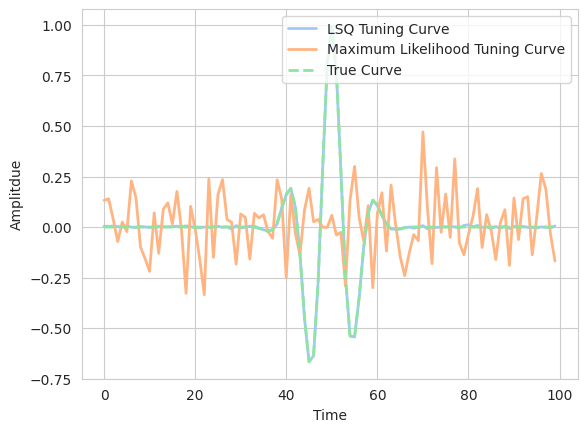

In [4]:
import matplotlib.pyplot as plt

fig = plt.figure()
ax = fig.gca()

f1 = ax.plot(lsqr_g, linewidth=2.0, label="LSQ Tuning Curve")
f2 = ax.plot(ml_g, linewidth=2.0, label="Maximum Likelihood Tuning Curve")
f3 = ax.plot(true_g, linestyle = '--', linewidth=2.0, label="True Curve")

ax.legend()

ax.set_xlabel("Time")
ax.set_ylabel("Amplitdue")

plt.show()


### How close is the estimate of $g$ to the real $g$

It is very close in the least squares sense after linearization. 

## Part C
Now use the actual known likelihood (in this case) to estimate $ g $ by setting up an optimization program using likelihood defined above. You should focus on defining the minimization program and then using the fminunc function in MATLAB.
Infer the tuning curve using $ M = N $ samples. 
* How accurate are the curves? 

The curves for low $N$ are not very accurate.
The largest difference between the scale at 50 and 100 are the amplitude differences. 

* What about for $ M = 2N $? $ M = N/2 $? 

The fit for 2N is a near perfect fit while for N/2 the fit is very poor. 

* Plot the estimates from Part C and Part B together. What do you notice about the estimates as the number of samples gets large?

I notice that as the number of samples gets larger, the fit improves. However, the computational takes much longer to complete. 


In [4]:
import seaborn as sns
from sthom215_problem_1_ex_2 import optimization, objMLL

N = 100
num_neurons = [N//2, N, 2*N]
n_trials = 100
resultsMLList = []

for num_neuron in num_neurons:
    resultsML = optimization(objMLL, num_neuron, n_trials)
    resultsMLList.append(resultsML)


/home/skyler/.local/lib/python3.10/site-packages/scipy/optimize/_minimize.py:708: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -491321.856823
         Iterations: 256
         Function evaluations: 37875
         Gradient evaluations: 375


/home/skyler/.local/lib/python3.10/site-packages/scipy/optimize/_minimize.py:708: OptimizeWarning: Maximum number of iterations has been exceeded.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -689547.967778
         Iterations: 1000
         Function evaluations: 114130
         Gradient evaluations: 1130
         Current function value: -980603.439199
         Iterations: 545
         Function evaluations: 62317
         Gradient evaluations: 617


/home/skyler/.local/lib/python3.10/site-packages/scipy/optimize/_minimize.py:708: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


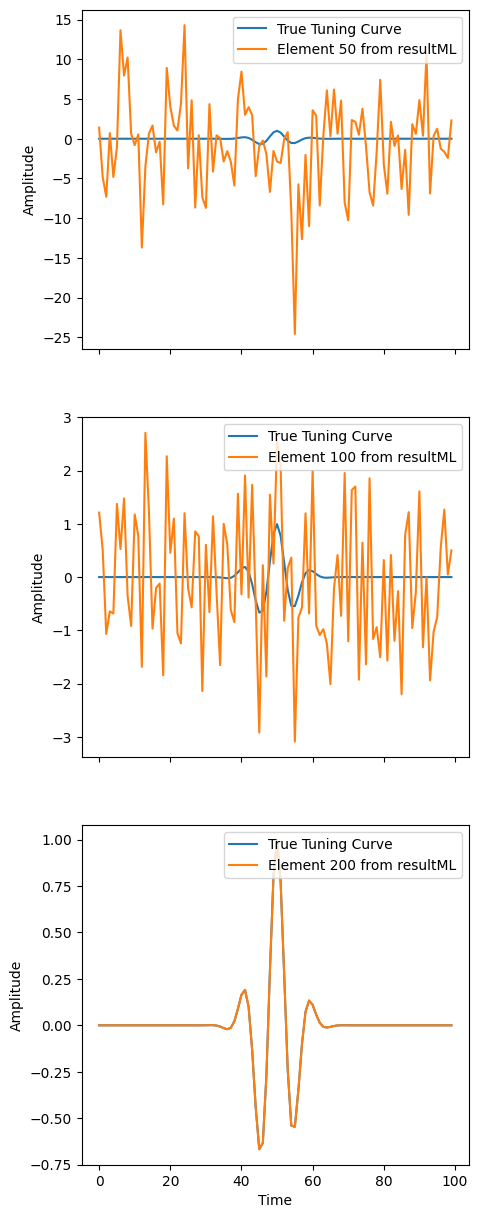

In [17]:
import matplotlib.pyplot as plt

num_neurons = [N//2, N, 2*N]

fig, axs = plt.subplots(3,1, figsize=(5, 15), sharex=True, sharey=False)

for i, element in enumerate(zip(resultsMLList, num_neurons)):
    line, num = element
    sns.lineplot(true_g, label='True Tuning Curve', ax = axs[i])
    sns.lineplot(line, label=f'Element {num} from resultML', ax = axs[i])
    axs[i].set_xlabel('Time')
    axs[i].set_ylabel('Amplitude')
    axs[i].legend()


plt.show()

## Part D
Adding in priors: Now let’s add some prior knowledge about the tuning curve. For the
Gaussian case, add a Gaussian prior $ p(g) \sim \mathcal{N}(0, \sigma^2I) $. Recall that with priors we change from
a maximum likelihood to a maximum a-posteriori (MAP) estimation. Use the definition of the
MAP estimate and Bayes rule to derive the estimator.

In [12]:
from sthom215_problem_1_ex_2 import objPriorUnregularized, optimization

num_nerurons = 100
n_trials = 100

resultMAP = optimization(objPriorUnregularized, num_nerurons, n_trials)


         Current function value: -689544.597898
         Iterations: 1000
         Function evaluations: 111504
         Gradient evaluations: 1104


/home/skyler/.local/lib/python3.10/site-packages/scipy/optimize/_minimize.py:708: OptimizeWarning: Maximum number of iterations has been exceeded.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


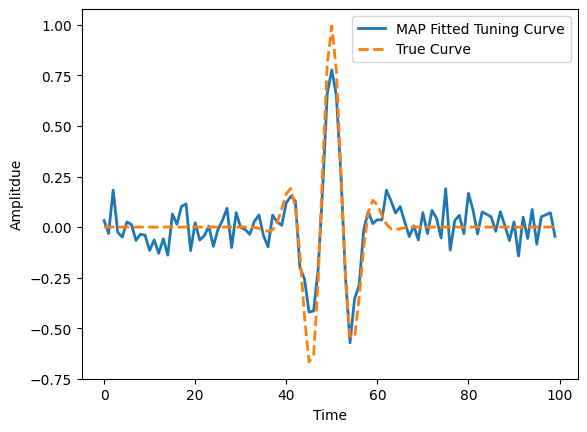

In [13]:
fig = plt.figure()
ax = fig.gca()


sns.lineplot(resultMAP, linewidth=2.0, label="MAP Fitted Tuning Curve", ax=ax)
sns.lineplot(true_g, linestyle = '--', linewidth=2.0, label="True Curve", ax=ax)
ax.set_xlabel("time")
ax.set_ylabel('ampltidue')

ax.legend()

ax.set_xlabel("Time")
ax.set_ylabel("Amplitdue")

plt.show()

### How does this change the optimization? 

The addition of the prior increases the computational time.

### How about the estimated tuning curve?

The addition of a prior makes the estimate more accurate for a smaller number of samples. 

### For the Poisson case, add a “smoothing” term $ p(\nabla g) \sim \mathcal{N}(0, \sigma^2I) $ (following the same procedure).

With the additional smoothing parameter by using the gradient we find that the minimization happens in fewer iterations compared to the case with the prior but without the regularization term.

In [ ]:
from sthom215_problem_1_ex_2 import objPriorRegularized, optimization

num_nerurons = 100
n_trials = 100

resultMAP = optimization(objPriorRegularized, num_nerurons, n_trials)

In [ ]:
import seaborn as sns
fig = plt.figure()
ax = fig.gca()


sns.lineplot(resultMAP, linewidth=2.0, label="MAP Fitted Tuning Curve", ax=ax)
sns.lineplot(true_g, linestyle = '--', linewidth=2.0, label="True Curve", ax=ax)
ax.set_xlabel("time")
ax.set_ylabel('ampltidue')

ax.legend()

ax.set_xlabel("Time")
ax.set_ylabel("Amplitdue")

plt.show()

### How does this affect the optimization? 

This makes the optimization converge faster.



### How about the estimated tuning curve?

It makes it look a little better.



# Part E Parameter regimes: 

Finally you should have code that generates a number of samples $M$
that probe an $ N $ dimensional receptive field. You should be able to change these parameters as well as the stimulus strength $ A $ (multiplier of $ X $) as well as the level of regularization (i.e., the variance of the prior $ \sigma $). Vary these parameters. 

* What happens at low signal levels? 
* How many samples do you need if $ A = 0.01 $? 
* Compare these observations with the histograms of the spike counts.

In [ ]:
from sthom215_problem_1_ex_2 import objPriorRegularized, optimization

num_nerurons = 100
n_trials = 100
A = 0.1
resultMAP = optimization(objPriorRegularized, num_nerurons, n_trials, stimulus_scale = A)